In [1]:
# # Uncomment this if using colab notebooks
# from google.colab import drive
# #
# drive.mount('/content/drive/')

Mounted at /content/drive/


# Libraries imports And Path Configuration

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pickle
import progressbar

In [3]:
# Specifiy the path to the folder containing the original given data (biological_data_pfp)
# PATH = '/content/drive/MyDrive/Padua/Classes/BioData/Biological Data Project/biological_data_pfp/'
PATH = './biological_data_pfp/'

TRAIN_SET_PATH = PATH + 'train/train_set.tsv'
ONTOLOGY_FILE_PATH = PATH + "train/go-basic.obo"

# files generated in other notebooks
npy_file_path_embeddings = PATH + 'train/train_embeddings.npy'
npy_file_path_ids = PATH + 'train/train_ids.npy'
domain_pca_embeddings_path = PATH + "train/domain_embeddings_pca.npy"
npy_file_path_ids_pca = PATH + 'train/domain_embeddings_pca_ids.npy'
IA_FILE_PATH = PATH + 'train/IA.txt'

# these are the paths for the files that will be generated by executing this notebook
GENERATED_TRAIN_SET_PATH = PATH + 'train/train.tsv'
GENERATED_VALIDATION_SET_PATH = PATH + 'train/validation.tsv'
# Use os to create the sorted_labels_per_aspect folder in the biological_data_pfp folder if it does not exist
if not os.path.exists(PATH + 'sorted_labels_per_aspect'):
    os.makedirs(PATH + 'sorted_labels_per_aspect')
LABELS_ORDER = PATH + 'sorted_labels_per_aspect/labels_mf.csv'

MODEL_PATH = PATH + 'models/MLP_molecular_function_final'
MODEL_HISTORY_PATH = PATH + 'models/training_history_MLP_molecular_function_final.pkl'

In [4]:
# Load the train and validation sets; created in data_preprocessing.ipynb by splitting the original train_set.tsv file
train_set_df = pd.read_csv(PATH + 'train/train.tsv', sep='\t')
validation_set_df = pd.read_csv(PATH + 'train/validation.tsv', sep='\t')

# Load the T5 embeddings

In [5]:
# Load embeddings from the numpy file
X_loaded = np.load(npy_file_path_embeddings)

# Load IDs from the numpy file
ids_loaded = np.load(npy_file_path_ids)

In [6]:
# Now lets convert embeddings numpy array(train_embeddings) into pandas dataframe.
column_num = X_loaded.shape[1]
t5_df = pd.DataFrame(X_loaded, columns = ["Column_" + str(i) for i in range(1, column_num+1)])
t5_df.set_index(pd.Index(ids_loaded), inplace=True)

print(t5_df.shape)

(123969, 1024)


In [7]:
# OPTIONAL: Can delete these loaded numpy arrays to free up memory
del X_loaded
del ids_loaded

# Load domain embeddings

In [8]:
domain_embeddings = np.load(domain_pca_embeddings_path)

In [9]:
domain_embeddings_ids = np.load(npy_file_path_ids_pca, allow_pickle=True)

In [10]:
# Now lets convert embeddings numpy array(train_embeddings) into pandas dataframe.
column_num = domain_embeddings.shape[1]
domains_df = pd.DataFrame(domain_embeddings, columns = ["Column_" + str(i+1024) for i in range(1, column_num+1)])
domains_df.set_index(pd.Index(domain_embeddings_ids), inplace=True)

print(domains_df.shape)

(117447, 1024)


In [11]:
# OPTIONAL: Can delete these loaded numpy arrays to free up memory
del domain_embeddings
del domain_embeddings_ids

# Combine the T5 and domain embeddings

In [12]:
# Combine the sequence and domain embeddings into one dataframe for the proteins; join based on the protein IDs
# - Reduces training set down to only proteins that have domain embedding information
complete_df = pd.merge(t5_df, domains_df, left_index=True, right_index=True, how='inner')

In [13]:
# OPTIONAL: Delete the dataframes to free up memory
del t5_df, domains_df

# Split the complete df with the features of train and test dataframes

In [14]:
# Determine the final train and validation sets based on the proteins that have both sequence and domain embeddings
train_df = complete_df[complete_df.index.isin(train_set_df['Protein_ID'])]
validation_df = complete_df[complete_df.index.isin(validation_set_df['Protein_ID'])]

In [15]:
train_df.shape

(93978, 2048)

In [16]:
validation_df.shape

(23469, 2048)

In [17]:
complete_df.shape

(117447, 2048)

In [18]:
print(train_df.shape[0] + validation_df.shape[0] == complete_df.shape[0])

True


# Extract only the data for Molecular Function

In [19]:
def split_dataframe_by_column(df, column_name):
    # Group the DataFrame by the specified column
    grouped = df.groupby(column_name)

    # Create a dictionary to store the resulting DataFrames
    result_dict = {}

    # Iterate through the groups and store each DataFrame in the dictionary
    for group, group_df in grouped:
        result_dict[group] = group_df

    return result_dict

train_set_splitted = split_dataframe_by_column(train_set_df, 'aspect')
validation_set_splitted = split_dataframe_by_column(validation_set_df, 'aspect')

In [20]:
train_set_aspect = train_set_splitted['molecular_function']
train_set_aspect

,Protein_ID,aspect,GO_term
13,O81027,molecular_function,GO:0016830
14,O81027,molecular_function,GO:0016829
15,O81027,molecular_function,GO:0016833
16,O81027,molecular_function,GO:0003824
17,O81027,molecular_function,GO:0003674
...,...,...,...
3418974,P28271,molecular_function,GO:0003676
3418975,P28271,molecular_function,GO:0003729
3418976,P28271,molecular_function,GO:0003723
3418977,P28271,molecular_function,GO:0097159


In [23]:
validation_set_aspect = validation_set_splitted['molecular_function']
validation_set_aspect

,Protein_ID,aspect,GO_term
26,P91124,molecular_function,GO:0005488
27,P91124,molecular_function,GO:0003674
28,P91124,molecular_function,GO:0005515
29,P91124,molecular_function,GO:0051020
30,P91124,molecular_function,GO:0019899
...,...,...,...
857823,P63001,molecular_function,GO:0036094
857824,P63001,molecular_function,GO:0032553
857825,P63001,molecular_function,GO:0019001
857826,P63001,molecular_function,GO:0035639


# Plot the distribution of GO Terms in train and validation sets

<ipython-input-21-2202a151dd47>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.barplot(ax=axis, x=np.array(plot_df.index), y=plot_df.values, palette=colors)


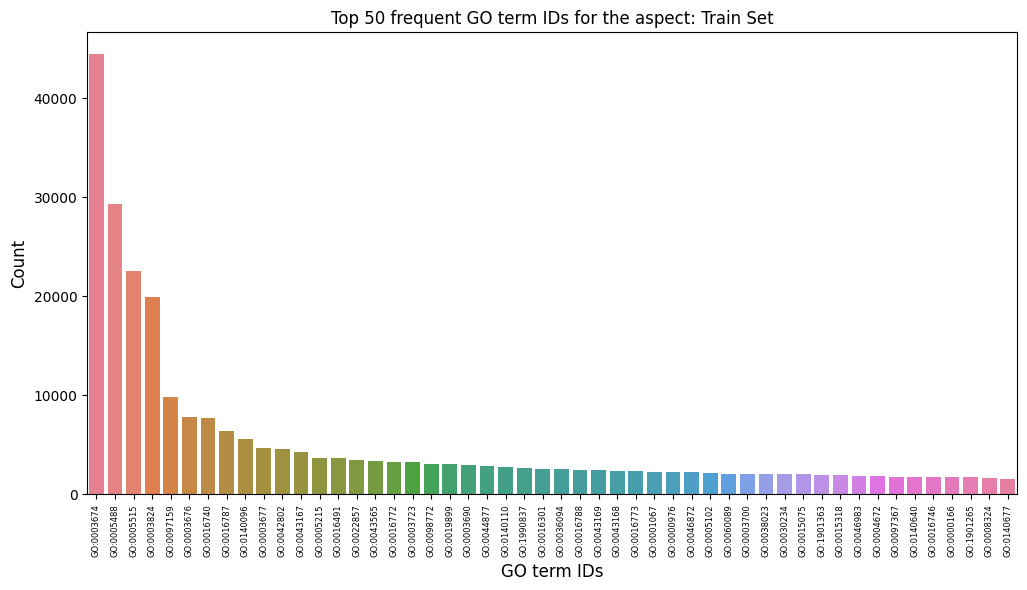

In [21]:
plot_df = train_set_aspect['GO_term'].value_counts().iloc[:50]

# Define a color palette (you can customize this list of colors)
colors = sns.color_palette("husl", len(plot_df))

# Create the plot
figure, axis = plt.subplots(1, 1, figsize=(12, 6))
bp = sns.barplot(ax=axis, x=np.array(plot_df.index), y=plot_df.values, palette=colors)

# Customize the plot
axis.set_xticks(np.arange(len(plot_df.index)))
bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size=6)
axis.set_title('Top 50 frequent GO term IDs for the aspect: Train Set')
bp.set_xlabel("GO term IDs", fontsize=12)
bp.set_ylabel("Count", fontsize=12)

plt.show()

<ipython-input-24-f9de50941139>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.barplot(ax=axis, x=np.array(plot_df.index), y=plot_df.values, palette=colors)


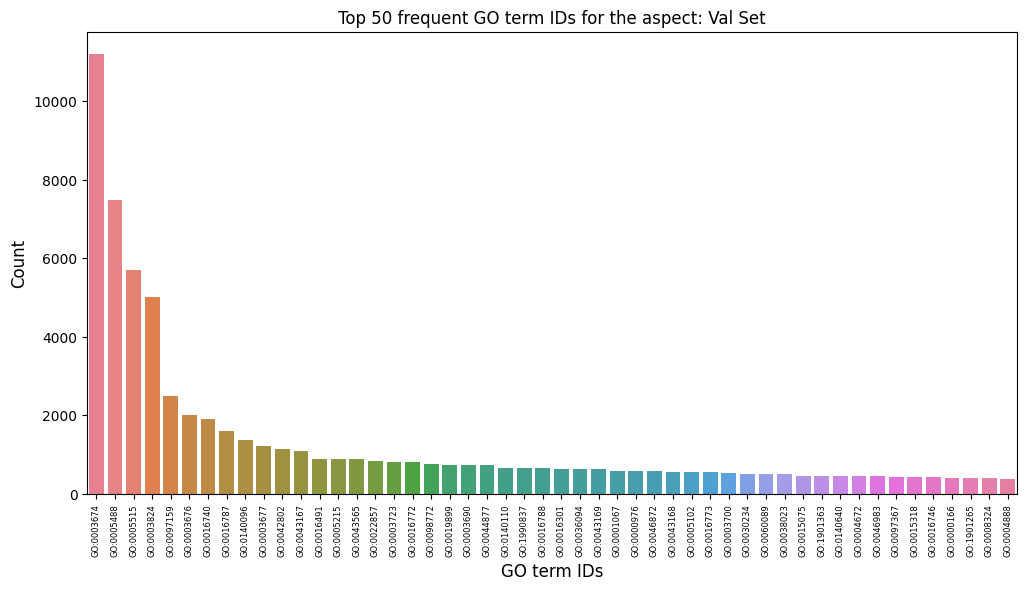

In [24]:
plot_df = validation_set_aspect['GO_term'].value_counts().iloc[:50]

# Define a color palette (you can customize this list of colors)
colors = sns.color_palette("husl", len(plot_df))

# Create the plot
figure, axis = plt.subplots(1, 1, figsize=(12, 6))
bp = sns.barplot(ax=axis, x=np.array(plot_df.index), y=plot_df.values, palette=colors)

# Customize the plot
axis.set_xticks(np.arange(len(plot_df.index)))
bp.set_xticklabels(bp.get_xticklabels(), rotation=90, size=6)
axis.set_title('Top 50 frequent GO term IDs for the aspect: Val Set')
bp.set_xlabel("GO term IDs", fontsize=12)
bp.set_ylabel("Count", fontsize=12)

plt.show()

In [ ]:
# Set the limit for label
num_of_labels = len(train_set_aspect['GO_term'].value_counts())

# Take value counts in descending order and fetch first 1500 `GO term ID` as labels
labels = train_set_aspect['GO_term'].value_counts().index[:num_of_labels].tolist()

# Save the order of the labels

In [ ]:
# Write labels to a CSV file
pd.DataFrame(labels, columns=['GO_term']).to_csv(LABELS_ORDER, header=False, index=False)

In [ ]:
# Fetch the train_terms data for the relevant labels only
train_terms_updated = train_set_aspect.loc[train_set_aspect['GO_term'].isin(labels)]
validation_terms_updated = validation_set_aspect.loc[validation_set_aspect['GO_term'].isin(labels)]

# One-hot encodding of the labels for train

In [ ]:
ids_to_load_train = np.array(train_df.index)

In [ ]:
# Setup progressbar settings.
# This is strictly for aesthetic.
bar = progressbar.ProgressBar(maxval=num_of_labels, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

# Create an empty dataframe of required size for storing the labels,
# i.e, train_size x num_of_labels (142246 x 1500)
train_size = ids_to_load_train.shape[0] # len(X)
train_labels = np.zeros((train_size ,num_of_labels))

# Convert from numpy to pandas series for better handling
series_train_protein_ids = pd.Series(ids_to_load_train)

# Loop through each label
bar.start()
for i in range(num_of_labels):
    # For each label, fetch the corresponding train_terms data
    n_train_terms = train_terms_updated[train_terms_updated['GO_term'] ==  labels[i]]

    # Fetch all the unique EntryId aka proteins related to the current label(GO term ID)
    label_related_proteins = n_train_terms['Protein_ID'].unique()

    # In the series_train_protein_ids pandas series, if a protein is related
    # to the current label, then mark it as 1, else 0.
    # Replace the ith column of train_Y with with that pandas series.
    train_labels[:,i] =  series_train_protein_ids.isin(label_related_proteins).astype(float)

    # Progress bar percentage increase
    bar.update(i+1)

# Notify the end of progress bar
bar.finish()

# Convert train_Y numpy into pandas dataframe
labels_df_train = pd.DataFrame(data = train_labels, columns = labels)
print(labels_df_train.shape)

(93978, 839)


In [ ]:
labels_df_train.index = ids_to_load_train

In [ ]:
# Count rows with at least one value of 1.0
rows_with_at_least_one_1 = (labels_df_train == 1.0).any(axis=1).sum()

# Count rows with all values set to 0.0
rows_with_all_zeros = (labels_df_train == 0.0).all(axis=1).sum()

print(f"Rows with at least one value of 1.0: {rows_with_at_least_one_1}")
print(f"Rows with all values set to 0.0: {rows_with_all_zeros}")

Rows with at least one value of 1.0: 43566
Rows with all values set to 0.0: 50412


# One-hot encodding of the labels for validation

In [ ]:
ids_to_load_validation = np.array(validation_df.index)

In [ ]:
# Setup progressbar settings.
# This is strictly for aesthetic.
bar = progressbar.ProgressBar(maxval=num_of_labels, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])

# Create an empty dataframe of required size for storing the labels,
# i.e, validation_size x num_of_labels (142246 x 1500)
validation_size = ids_to_load_validation.shape[0] # len(X)
validation_labels = np.zeros((validation_size ,num_of_labels))

# Convert from numpy to pandas series for better handling
series_validation_protein_ids = pd.Series(ids_to_load_validation)

# Loop through each label
bar.start()
for i in range(num_of_labels):
    # For each label, fetch the corresponding validation_terms data
    n_validation_terms = validation_terms_updated[validation_terms_updated['GO_term'] ==  labels[i]]

    # Fetch all the unique EntryId aka proteins related to the current label(GO term ID)
    label_related_proteins = n_validation_terms['Protein_ID'].unique()

    # In the series_validation_protein_ids pandas series, if a protein is related
    # to the current label, then mark it as 1, else 0.
    # Replace the ith column of validation_Y with with that pandas series.
    validation_labels[:,i] =  series_validation_protein_ids.isin(label_related_proteins).astype(float)

    # Progress bar percentage increase
    bar.update(i+1)

# Notify the end of progress bar
bar.finish()

# Convert validation_Y numpy into pandas dataframe
labels_df_validation = pd.DataFrame(data = validation_labels, columns = labels)
print(labels_df_validation.shape)

(23469, 839)


In [ ]:
labels_df_validation.index = ids_to_load_validation

In [ ]:
# Count rows with at least one value of 1.0
rows_with_at_least_one_1 = (labels_df_validation == 1.0).any(axis=1).sum()

# Count rows with all values set to 0.0
rows_with_all_zeros = (labels_df_validation == 0.0).all(axis=1).sum()

print(f"Rows with at least one value of 1.0: {rows_with_at_least_one_1}")
print(f"Rows with all values set to 0.0: {rows_with_all_zeros}")

Rows with at least one value of 1.0: 10979
Rows with all values set to 0.0: 12490


# Order the features df and the labels df according to their index (Protein_ID)

In [ ]:
# Reindex both DataFrames based on the sorted order of the IDs for the training set
sorted_ids = sorted(train_df.index)
train_df = train_df.reindex(sorted_ids)
labels_df_train = labels_df_train.reindex(sorted_ids)

In [ ]:
# Reindex both DataFrames based on the sorted order of the IDs for the validation set
sorted_ids = sorted(validation_df.index)
validation_df = validation_df.reindex(sorted_ids)
labels_df_validation = labels_df_validation.reindex(sorted_ids)

# Train the model

In [ ]:
class RegularizedLinearModel(tf.keras.Model):
    def __init__(self, input_dim, hidden_dim, num_classes, dropout_rate=0.2):
        super(RegularizedLinearModel, self).__init__()
        self.linear1 = tf.keras.layers.Dense(hidden_dim, input_dim=input_dim)
        self.dropout1 = tf.keras.layers.Dropout(dropout_rate)
        self.activation1 = tf.keras.layers.ReLU()
        self.linear2 = tf.keras.layers.Dense(num_classes, activation='sigmoid')

    def call(self, x):
        x = self.linear1(x)
        x = self.dropout1(x)
        x = self.activation1(x)
        x = self.linear2(x)
        return x

input_dim = train_df.shape[1]
hidden_dim = 512
num_classes = num_of_labels

model = RegularizedLinearModel(input_dim, hidden_dim, num_classes)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss='binary_crossentropy',
    metrics=[
        tf.keras.metrics.BinaryAccuracy(),
        tf.keras.metrics.AUC(multi_label=True),
        tf.keras.metrics.F1Score(threshold=0.2),
    ],
)

validation_data = (validation_df, labels_df_validation)

history = model.fit(
    train_df, labels_df_train,
    batch_size=256,
    epochs=50,
    validation_data=validation_data
)


Epoch 1/50
368/368 [==============================] - 11s 26ms/step - loss: 0.0259 - binary_accuracy: 0.9935 - auc: 0.7233 - f1_score: 0.0642 - val_loss: 0.0155 - val_binary_accuracy: 0.9950 - val_auc: 0.8467 - val_f1_score: 0.2307
Epoch 2/50
368/368 [==============================] - 8s 23ms/step - loss: 0.0149 - binary_accuracy: 0.9951 - auc: 0.8745 - f1_score: 0.2970 - val_loss: 0.0147 - val_binary_accuracy: 0.9951 - val_auc: 0.8877 - val_f1_score: 0.3101
Epoch 3/50
368/368 [==============================] - 8s 22ms/step - loss: 0.0142 - binary_accuracy: 0.9952 - auc: 0.8997 - f1_score: 0.3397 - val_loss: 0.0143 - val_binary_accuracy: 0.9952 - val_auc: 0.8917 - val_f1_score: 0.3343
Epoch 4/50
368/368 [==============================] - 8s 22ms/step - loss: 0.0136 - binary_accuracy: 0.9953 - auc: 0.9120 - f1_score: 0.3708 - val_loss: 0.0143 - val_binary_accuracy: 0.9952 - val_auc: 0.8910 - val_f1_score: 0.3583
Epoch 5/50
368/368 [==============================] - 8s 22ms/step - loss: 

In [ ]:
# Save the trained model
model.save(MODEL_PATH)

# Optionally, save the training history to analyze later
with open(MODEL_HISTORY_PATH, 'wb') as file:
    pickle.dump(history.history, file)

INFO:tensorflow:Assets written to: ./biological_data_pfp/models/MLP_molecular_function_final\assets


INFO:tensorflow:Assets written to: ./biological_data_pfp/models/MLP_molecular_function_final\assets


# Load the model

In [ ]:
model = tf.keras.models.load_model(MODEL_PATH)

# Analyze train and validation datasets to understand why the results are better on the training set

In [ ]:
predictions = model.predict(train_df)

2937/2937 [==============================] - 9s 3ms/step


In [ ]:
predictions.shape

(93978, 839)

In [ ]:
threshold = 0.2

binary_predictions = np.where(predictions > threshold, 1, 0)

In [ ]:
from sklearn.metrics import precision_recall_fscore_support
precision, recall, f1_score, _ = precision_recall_fscore_support(labels_df_train, binary_predictions, average='weighted')

In [ ]:
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1-Score: {:.4f}".format(f1_score))

Precision: 0.6380
Recall: 0.8605
F1-Score: 0.7249


In [ ]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(labels_df_train, binary_predictions)

# Print the classification report
print(report)

              precision    recall  f1-score   support

           0       0.61      0.98      0.75     43566
           1       0.54      0.93      0.68     28587
           2       0.47      0.90      0.61     22058
           3       0.67      0.96      0.79     19707
           4       0.62      0.85      0.72      9621
           5       0.64      0.89      0.75      7547
           6       0.69      0.97      0.81      7562
           7       0.73      0.91      0.81      6257
           8       0.63      0.94      0.76      5444
           9       0.66      0.89      0.76      4580
          10       0.50      0.51      0.50      4413
          11       0.63      0.71      0.67      4164
          12       0.69      0.95      0.80      3566
          13       0.71      0.95      0.81      3556
          14       0.71      0.96      0.82      3378
          15       0.64      0.90      0.75      3292
          16       0.72      0.96      0.82      3205
          17       0.57    

C:\Users\camer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\camer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
predictions_val = model.predict(validation_df)

734/734 [==============================] - 2s 3ms/step


In [ ]:
binary_predictions_val = np.where(predictions_val > threshold, 1, 0)

In [ ]:
precision_val, recall_val, f1_score_val, _ = precision_recall_fscore_support(labels_df_validation, binary_predictions_val, average='weighted')

C:\Users\camer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("Val Precision: {:.4f}".format(precision_val))
print("Val Recall: {:.4f}".format(recall_val))
print("Val F1-Score: {:.4f}".format(f1_score_val))

Val Precision: 0.4484
Val Recall: 0.5885
Val F1-Score: 0.5002


In [ ]:
# Generate classification report
report_val = classification_report(labels_df_validation, binary_predictions_val)

# Print the classification report
print(report_val)

              precision    recall  f1-score   support

           0       0.55      0.90      0.68     10979
           1       0.44      0.76      0.55      7311
           2       0.37      0.71      0.48      5593
           3       0.58      0.84      0.68      4965
           4       0.42      0.56      0.48      2445
           5       0.46      0.61      0.53      1946
           6       0.56      0.77      0.65      1884
           7       0.57      0.68      0.62      1583
           8       0.52      0.74      0.61      1363
           9       0.49      0.62      0.55      1191
          10       0.23      0.22      0.23      1112
          11       0.28      0.27      0.27      1074
          12       0.55      0.76      0.64       883
          13       0.62      0.80      0.70       885
          14       0.57      0.78      0.66       839
          15       0.48      0.63      0.54       866
          16       0.57      0.74      0.65       797
          17       0.39    

C:\Users\camer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\camer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\camer\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\metrics\_classification.py:1344: Unde

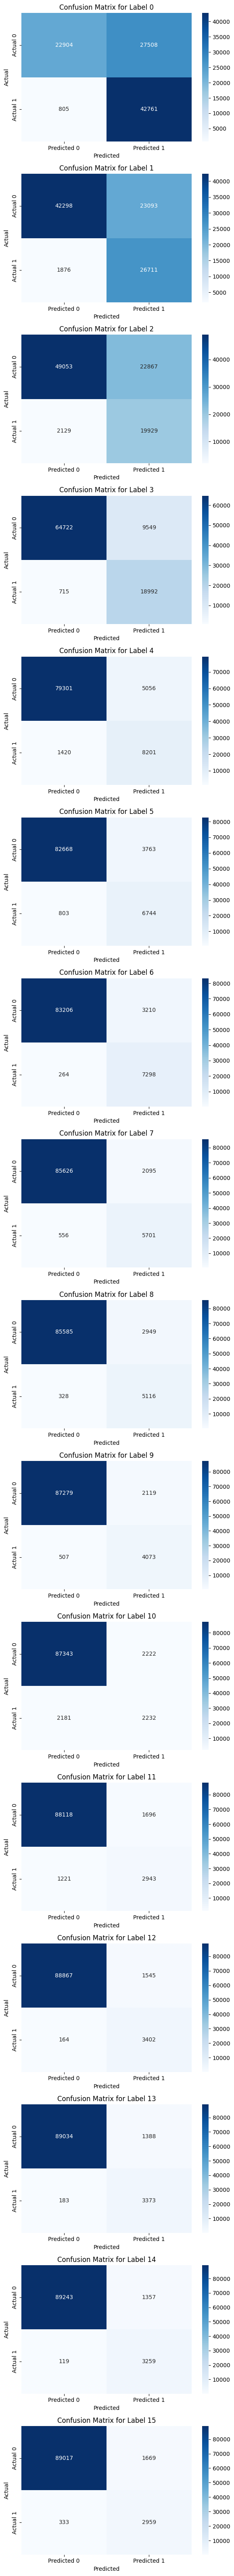

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

multilabel_cm = multilabel_confusion_matrix(labels_df_train, binary_predictions)

# Define the range of labels you want to plot
start_label, end_label = 0, 15

# Plot confusion matrix for the selected labels
num_labels = end_label - start_label + 1
fig, axes = plt.subplots(num_labels, 1, figsize=(6, 4 * num_labels))

for i in range(start_label, end_label + 1):
    label_index = i - start_label
    ax = axes[label_index]
    sns.heatmap(multilabel_cm[i], annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'], ax=ax)
    ax.set_title(f'Confusion Matrix for Label {i}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

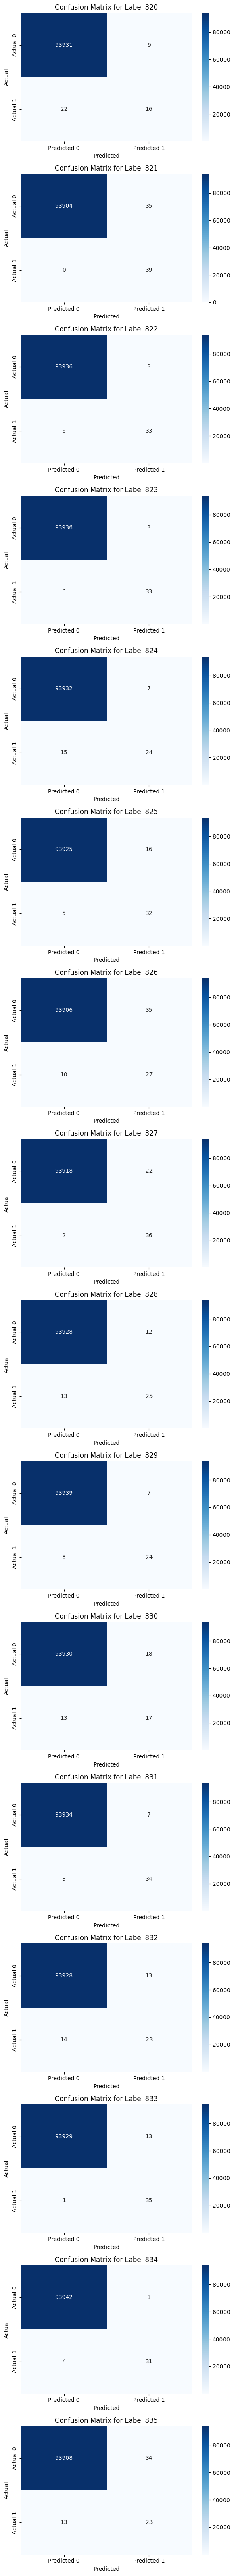

In [ ]:
multilabel_cm = multilabel_confusion_matrix(labels_df_train, binary_predictions)

# Define the range of labels you want to plot
start_label, end_label = 820, 835

# Plot confusion matrix for the selected labels
num_labels = end_label - start_label + 1
fig, axes = plt.subplots(num_labels, 1, figsize=(6, 4 * num_labels))

for i in range(start_label, end_label + 1):
    label_index = i - start_label
    ax = axes[label_index]
    sns.heatmap(multilabel_cm[i], annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'], ax=ax)
    ax.set_title(f'Confusion Matrix for Label {i}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

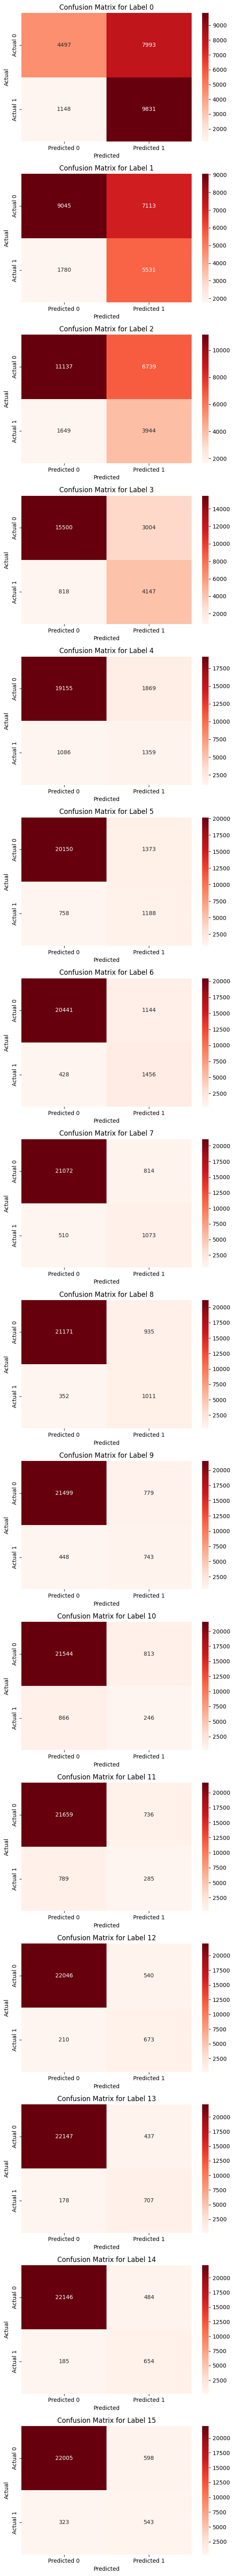

In [ ]:
multilabel_cm = multilabel_confusion_matrix(labels_df_validation, binary_predictions_val)

# Define the range of labels you want to plot
start_label, end_label = 0, 15

# Plot confusion matrix for the selected labels
num_labels = end_label - start_label + 1
fig, axes = plt.subplots(num_labels, 1, figsize=(6, 4 * num_labels))

for i in range(start_label, end_label + 1):
    label_index = i - start_label
    ax = axes[label_index]
    sns.heatmap(multilabel_cm[i], annot=True, fmt='d', cmap='Reds', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'], ax=ax)
    ax.set_title(f'Confusion Matrix for Label {i}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

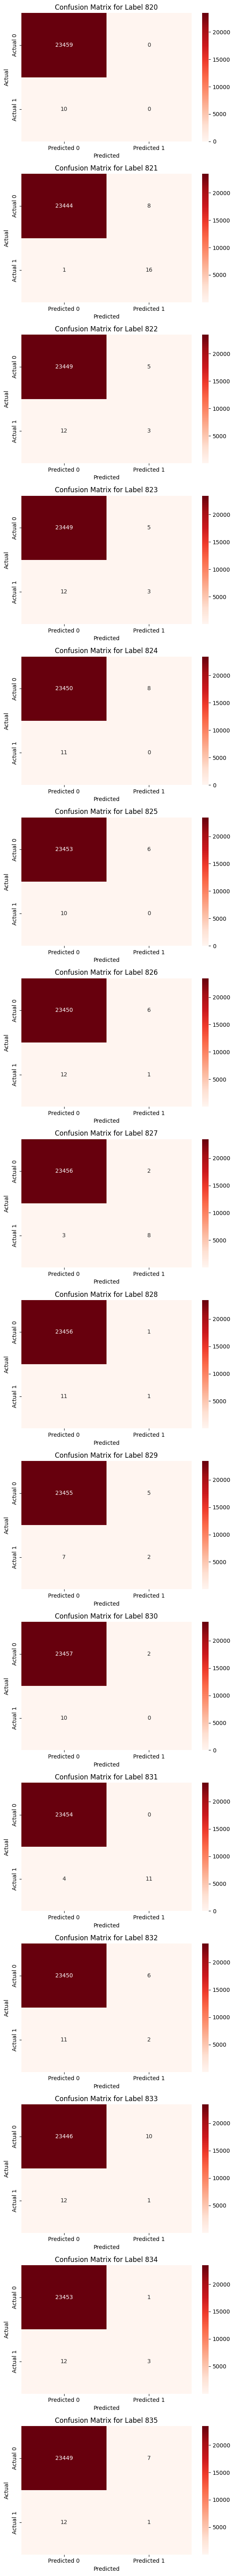

In [ ]:
multilabel_cm = multilabel_confusion_matrix(labels_df_validation, binary_predictions_val)

# Define the range of labels you want to plot
start_label, end_label = 820, 835

# Plot confusion matrix for the selected labels
num_labels = end_label - start_label + 1
fig, axes = plt.subplots(num_labels, 1, figsize=(6, 4 * num_labels))

for i in range(start_label, end_label + 1):
    label_index = i - start_label
    ax = axes[label_index]
    sns.heatmap(multilabel_cm[i], annot=True, fmt='d', cmap='Reds', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'], ax=ax)
    ax.set_title(f'Confusion Matrix for Label {i}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

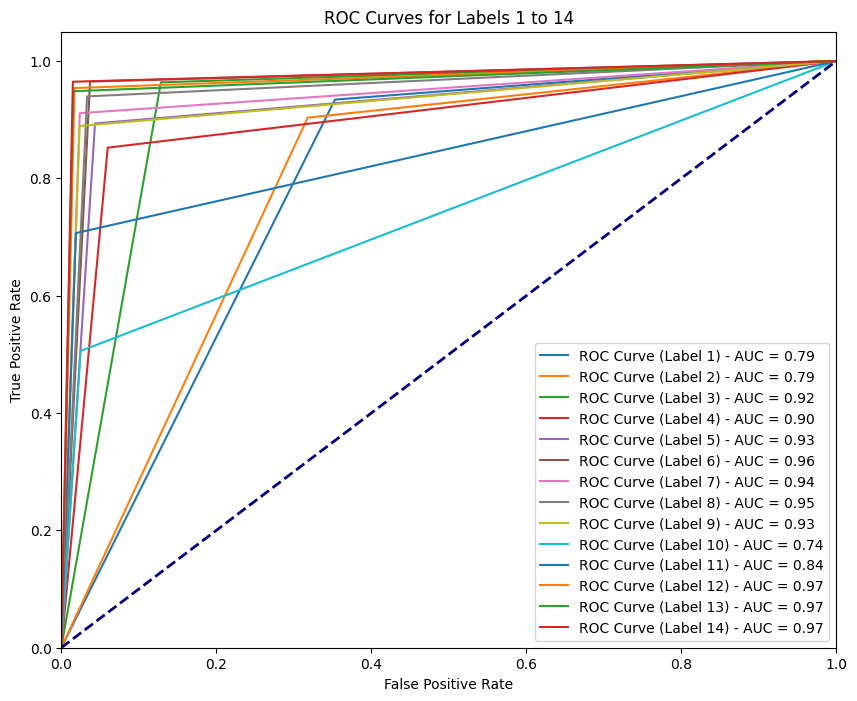

In [ ]:
from sklearn.metrics import roc_curve, auc

# Convert them to numpy arrays
labels_array = labels_df_train.to_numpy()

# Specify the range of labels you want to plot
start_label = 1
end_label = 15

# Initialize variables to store fpr, tpr, and auc for each label
all_fpr = []
all_tpr = []
all_auc = []

# Loop through each label in the specified range
for i in range(start_label, end_label):
    fpr, tpr, thresholds = roc_curve(labels_array[:, i], binary_predictions[:, i])
    roc_auc = auc(fpr, tpr)

    # Append fpr, tpr, and auc to the lists
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(roc_auc)

# Plot ROC curves for each label in the specified range
plt.figure(figsize=(10, 8))
for i in range(len(all_fpr)):
    plt.plot(all_fpr[i], all_tpr[i], label=f'ROC Curve (Label {start_label + i}) - AUC = {all_auc[i]:.2f}')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves for Labels {start_label} to {end_label-1}')
plt.legend(loc='lower right')
plt.show()


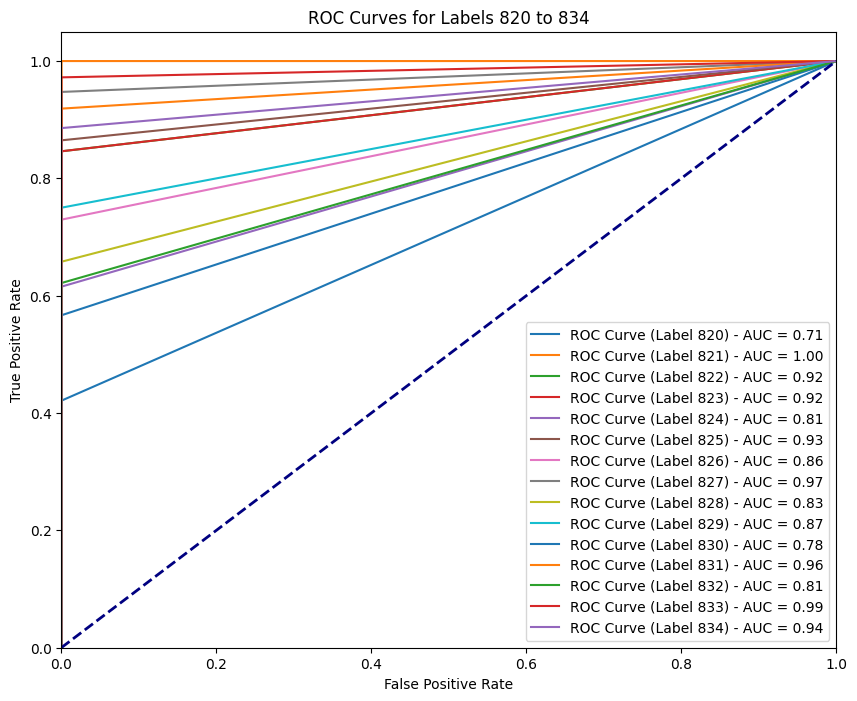

In [ ]:
# Convert them to numpy arrays
labels_array = labels_df_train.to_numpy()

# Specify the range of labels you want to plot
start_label = 820
end_label = 835

# Initialize variables to store fpr, tpr, and auc for each label
all_fpr = []
all_tpr = []
all_auc = []

# Loop through each label in the specified range
for i in range(start_label, end_label):
    fpr, tpr, thresholds = roc_curve(labels_array[:, i], binary_predictions[:, i])
    roc_auc = auc(fpr, tpr)

    # Append fpr, tpr, and auc to the lists
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(roc_auc)

# Plot ROC curves for each label in the specified range
plt.figure(figsize=(10, 8))
for i in range(len(all_fpr)):
    plt.plot(all_fpr[i], all_tpr[i], label=f'ROC Curve (Label {start_label + i}) - AUC = {all_auc[i]:.2f}')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves for Labels {start_label} to {end_label-1}')
plt.legend(loc='lower right')
plt.show()


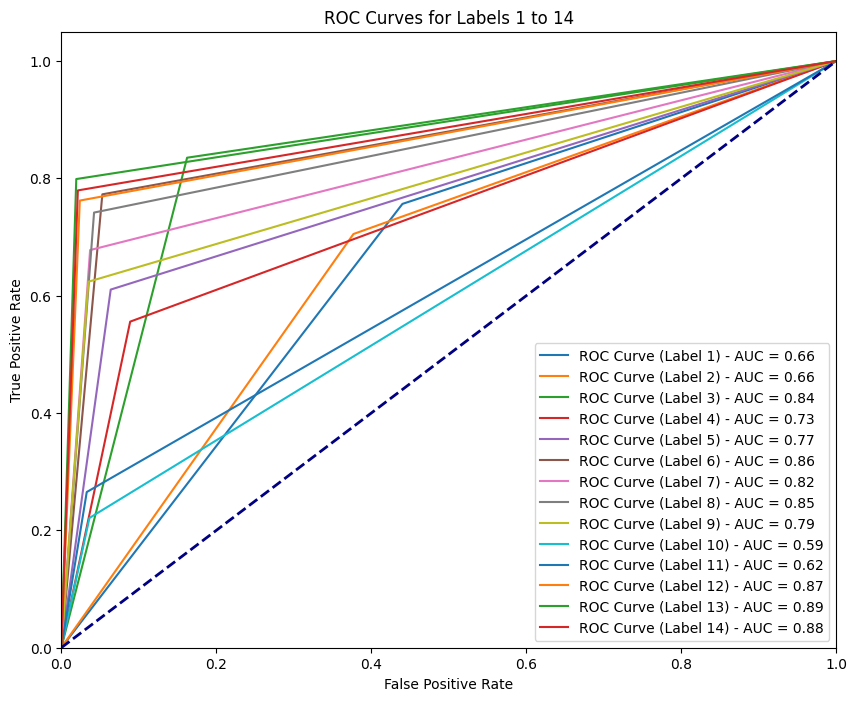

In [ ]:
# Convert them to numpy arrays
labels_array = labels_df_validation.to_numpy()

# Specify the range of labels you want to plot
start_label = 1
end_label = 15

# Initialize variables to store fpr, tpr, and auc for each label
all_fpr = []
all_tpr = []
all_auc = []

# Loop through each label in the specified range
for i in range(start_label, end_label):
    fpr, tpr, thresholds = roc_curve(labels_array[:, i], binary_predictions_val[:, i])
    roc_auc = auc(fpr, tpr)

    # Append fpr, tpr, and auc to the lists
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(roc_auc)

# Plot ROC curves for each label in the specified range
plt.figure(figsize=(10, 8))
for i in range(len(all_fpr)):
    plt.plot(all_fpr[i], all_tpr[i], label=f'ROC Curve (Label {start_label + i}) - AUC = {all_auc[i]:.2f}')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves for Labels {start_label} to {end_label-1}')
plt.legend(loc='lower right')
plt.show()


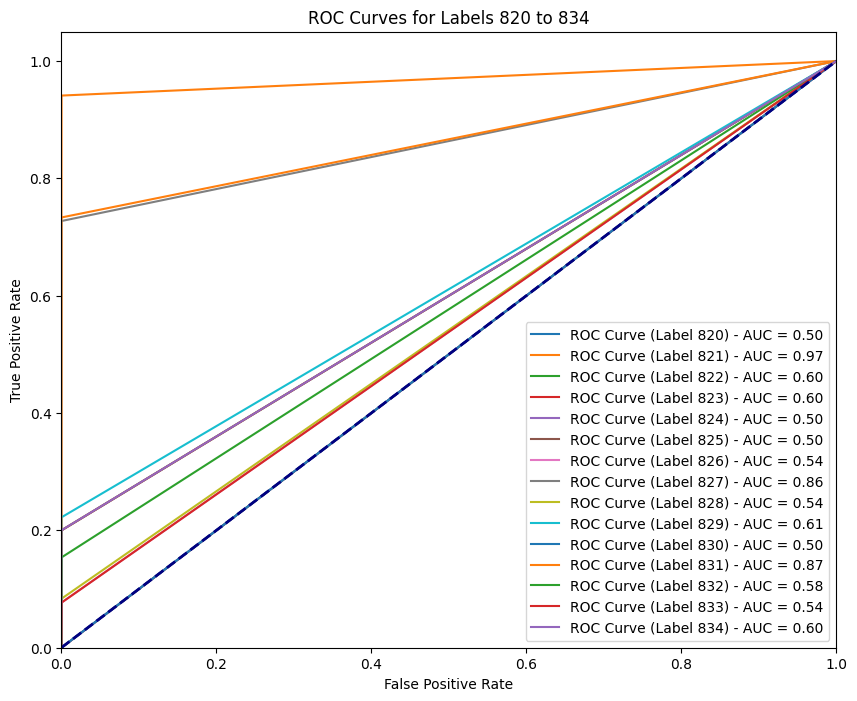

In [ ]:
# Convert them to numpy arrays
labels_array = labels_df_validation.to_numpy()

# Specify the range of labels you want to plot
start_label = 820
end_label = 835

# Initialize variables to store fpr, tpr, and auc for each label
all_fpr = []
all_tpr = []
all_auc = []

# Loop through each label in the specified range
for i in range(start_label, end_label):
    fpr, tpr, thresholds = roc_curve(labels_array[:, i], binary_predictions_val[:, i])
    roc_auc = auc(fpr, tpr)

    # Append fpr, tpr, and auc to the lists
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_auc.append(roc_auc)

# Plot ROC curves for each label in the specified range
plt.figure(figsize=(10, 8))
for i in range(len(all_fpr)):
    plt.plot(all_fpr[i], all_tpr[i], label=f'ROC Curve (Label {start_label + i}) - AUC = {all_auc[i]:.2f}')

plt.plot([0, 1], [0, 1], color='navy', linestyle='--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curves for Labels {start_label} to {end_label-1}')
plt.legend(loc='lower right')
plt.show()
